In [1]:
!nvidia-smi

Wed Jul  3 12:43:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0    25W /  N/A |    202MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets as ds, models, transforms as tf, utils

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

# Data

In [4]:
class SpacenetVegas(ds.VisionDataset):
    def __init__(self, path='data', x_folder='train-img', y_folder='train-labels', exts=['npy'], load_fn=np.load, x_tf=None, y_tf=None, cache=None):
        super(SpacenetVegas).__init__()
        self.x_path = f'{path}/{x_folder}'
        self.y_path = f'{path}/{y_folder}'
        self._load_filenames(path, x_folder, y_folder, exts)
        
        self.x_tf = x_tf or (lambda x: x)
        self.y_tf = y_tf or (lambda x: x)
        self.x_tf2 = RandomFlip()

#         self.cache = {i: self._load_xy_from_file(i) for i in range(len(self.fnames))}
        if cache is None:
            self.cache = {}
            for i in range(len(self.fnames)):
                self.cache[i] = self._load_xy_from_file(i)
                if (i + 1) % 1000 == 0:
                    print(f'Cached {len(self.cache)}  x, y pairs')
        else:
            self.cache = cache

        self.is_small_class = torch.ByteTensor([v[1] for v in self.cache.values()])

        print(f'Found {len(self.fnames)} x, y pairs')
        print(f'Cached {len(self.cache)}  x, y pairs')
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, i):
        if isinstance(i, (int, np.integer)):
            return self._load_xy(i)
        if isinstance(i, np.ndarray) or isinstance(i, torch.Tensor):
            i = i.squeeze()
            assert i.ndim in (0, 1), "too many dimensions"
            if i.ndim == 0:
                return self._load_xy(i)
            return [self._load_xy(j) for j in i]
        if isinstance(i, slice):
            return [self._load_xy(j) for j in range(*i.indices(len(self.fnames)))]
        assert False, f"__getitem__(i): Invalid index"

#     def get_x(self, i):
#         if isinstance(i, (int, np.integer)):
#             return self._load_xy(i)
#         if isinstance(i, np.ndarray) or isinstance(i, torch.Tensor):
#             i = i.squeeze()
#             assert i.ndim in (0, 1), "too many dimensions"
#             if i.ndim == 0:
#                 return _load_x(i)
#             return [self._load_x(j) for j in i]
#         if isinstance(i, slice):
#             return [self._load_x(j) for j in range(*i.indices(len(self.fnames)))]
#         assert False, f"__getitem__(i): Invalid index"

    def _load_x(self, i):
        return self.cache[i][0]

    def _load_xy(self, i):
        x, y = self.cache[i]
        return self.x_tf2(x), y

    def _load_xy_from_file(self, i):
        x = np.load(f'{self.x_path}/{self.fnames[i]}').astype(float) / 255
        y = np.load(f'{self.y_path}/{self.fnames[i]}')
        
        return self.x_tf(x), self.y_tf(y)

    def _load_filenames(self, path, x_folder, y_folder, exts):
        query_expr = f"*[{'|'.join('.' + ext for ext in exts)}]"
        print(f'{self.x_path}/{query_expr}/')
        x_fnames = [Path(f).name for f in glob(f'{self.x_path}/{query_expr}')]
        y_fnames = [Path(f).name for f in glob(f'{self.y_path}/{query_expr}')]
        self._verify_xy_pairs(x_fnames, y_fnames)
        
        self.fnames = x_fnames

    def _verify_xy_pairs(self, x_fnames, y_fnames):
         assert set(x_fnames) == set(y_fnames)

## Transforms

In [5]:
class Downsample(object):
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, arr):
        return np.ascontiguousarray(arr[::self.factor, ::self.factor])
    
    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


class RandomFlip(object):
    def __init__(self, h_prob=0.5, v_prob=0.5):
        self.h_prob = h_prob
        self.v_prob = v_prob
    
    def __call__(self, arr):
        if torch.rand(1) < self.v_prob:
            arr = arr.flip(1)
        if torch.rand(1) < self.h_prob:
            arr = arr.flip(2)
        return arr

    def __repr__(self):
        return self.__class__.__name__ + f'(h_prob={self.h_prob}, v_prob={self.v_prob})'


class ChannelSelect(object):
    def __init__(self, channels):
        self.channels = channels
    
    def __call__(self, arr):
        return np.ascontiguousarray(arr[..., self.channels])

    def __repr__(self):
        return self.__class__.__name__ + f'(channels={self.channels})'
    


In [28]:
channels = [7, 6, 5]
# channels = [4, 2, 1]

train_transform = tf.Compose([
    ChannelSelect(channels),
    Downsample(8),
    tf.Lambda(lambda x: (torch.Tensor(x).permute(2, 0, 1)))
])

val_transform = tf.Compose([
    ChannelSelect(channels),
    Downsample(8),
    tf.Lambda(lambda x: torch.Tensor(x).permute(2, 0, 1))
])

y_transform = tf.Compose([
    Downsample(8),
    tf.Lambda(lambda x: (torch.Tensor(x) == 1).any().long())
])

print('train_transform', train_transform)
print('val_transform', val_transform)
print('y_transform', y_transform)

train_transform Compose(
    ChannelSelect(channels=[7, 6, 5])
    Downsample(factor=8)
    Lambda()
)
val_transform Compose(
    ChannelSelect(channels=[7, 6, 5])
    Downsample(factor=8)
    Lambda()
)
y_transform Compose(
    Downsample(factor=8)
    Lambda()
)


In [29]:
import pickle

# with open('train_ds_753_2.pkl', 'wb') as f:
#     pickle.dump(train_ds.cache, f)

with open('train_ds_765_2.pkl', 'rb') as f:
    cache = pickle.load(f)

In [30]:
import copy

# train_ds = SpacenetVegas(x_tf=train_transform, y_tf=y_transform)
train_ds = SpacenetVegas(x_tf=train_transform, y_tf=y_transform, cache=cache)
# val_ds   = SpacenetVegas(x_tf=val_transform  , y_tf=y_transform)
val_ds   = copy.deepcopy(train_ds)

assert len(train_ds) == len(val_ds)

data/train-img/*[.npy]/
Found 17334 x, y pairs
Cached 17334  x, y pairs


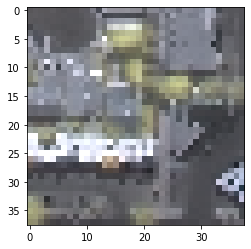

In [31]:
train_ds.x_tf2 = RandomFlip()
val_ds.x_tf2 = lambda x: x
plt.imshow(train_ds[0][0].permute(1, 2, 0))

In [32]:
len(train_ds.cache), len(val_ds.cache)

(17334, 17334)

In [33]:
# train_ds.is_small_class = torch.ByteTensor([v[1] for v in train_ds.cache.values()])
# (1-train_ds.is_small_class).sum()

In [34]:
train_split_size = int(len(train_ds) * .85 // 1)
val_split_size = len(train_ds) - train_split_size
train_split_size, val_split_size

inds = np.arange(len(train_ds))
np.random.shuffle(inds)

In [35]:
train_sampler = data.SubsetRandomSampler(inds[:train_split_size])
val_sampler = data.SubsetRandomSampler(inds[train_split_size:])

# Model

In [16]:
class ClfModel(nn.Module):

    def __init__(self, params):
        super().__init__()

        self.net = params['base_model']
        self.net.fc = nn.Linear(self.net.fc.in_features, params['nclasses'])

    def forward(self, X):
        out = self.net(X)
        return out


In [17]:
model_params = {}
model_params['base_model'] = models.resnet18(pretrained=False).cuda()
model_params['nclasses'] = 2


In [18]:
model_RGB = ClfModel(model_params).cuda()
model_RGB.net._modules['conv1'] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).cuda()
model_RGB.net._modules['maxpool'] = nn.Identity().cuda()

In [46]:
model_save_name = 'resnet18_421_3x3'
path = F"models/{model_save_name}"
state = torch.load(path)
model_RGB.load_state_dict(state['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [48]:
model = model_RGB

In [49]:
for p in model.parameters():
    p.requires_grad = False

for p in model.net._modules['conv1'].parameters():
    p.requires_grad = True
    
for p in model.net._modules['bn1'].parameters():
    p.requires_grad = True

# model_RGB

In [73]:

# for p in model.net._modules['conv1'].parameters():
#     print(p.requires_grad)
    
# for p in model.net._modules['layer1'][0]._modules['bn1'].parameters():
#     print(p.requires_grad)

True


# Training

In [20]:
def save_model(model, name, info={}):
    state = {
        'model': model.state_dict(),
        'info': info
    }
    path = F"models/{name}" 
    torch.save(state, path)

In [21]:
import time

    
def validate(model, criterion, val_dl):
    
    val_loss = 0.
    val_corrects = 0
    model.eval()
    for i, (batch, labels) in enumerate(val_dl):
        N = batch.shape[0]
        batch = batch.cuda()

        preds = model(batch).detach().cpu()
        val_loss += criterion(preds, labels)
        val_corrects += (preds.argmax(dim=-1) == labels).detach().cpu().float().sum()

    val_acc = val_corrects.float() / len(val_dl.sampler)
    return val_loss, val_acc


def train_epoch(model, train_dl, criterion, optimizer):
    
    epoch_loss = 0.
    train_corrects = 0

    model.train()
    for i, (batch, labels) in enumerate(train_dl):
        N = batch.shape[0]
        batch = batch.cuda()
        labels = labels.cuda()

        preds = model(batch)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().cpu()
        train_corrects += (preds.argmax(dim=-1) == labels).detach().cpu().float().sum()

    train_acc = train_corrects.float() / len(train_dl.sampler)
    return epoch_loss, train_acc


def train_clf(model, train_dl, val_dl, optimizer, sched, params, callback=lambda x: None, save_name='model', best_acc=0.85):

    criterion = nn.CrossEntropyLoss()

    torch.cuda.empty_cache()
    for epoch in range(params['epochs']):
        start_time = time.time()

        # train (fwd pass and backprop)
        epoch_loss, train_acc = train_epoch(model, train_dl, criterion, optimizer)

        # validate
        val_loss, val_acc = validate(model, criterion, val_dl)

        # save best model so far
        if val_acc >= (best_acc + 0.005) and val_acc > 0.8:
            best_acc = val_acc
            info = {'acc': val_acc, 'epoch': epoch, 'val_loss': val_loss, 'lr': optimizer.param_groups[0]['lr']}
            save_model(model, save_name, info=info)

        print('epoch: %3d, lr: %0.8f, epoch_loss: %4.4f, val_loss: %4.4f, train_acc: %0.4f, val_acc: %0.4f, best: %0.4f, time: %0.1f' % (epoch, optimizer.param_groups[0]['lr'], epoch_loss, val_loss, train_acc, val_acc, best_acc, time.time() - start_time))
        sched.step()
        callback(model)
    

In [22]:
model = model_RGB

train_params = {}
train_params['batch_size'] = 64
train_params['val_batch_size'] = 512


In [23]:
train_dl = data.DataLoader(train_ds, sampler=train_sampler, batch_size=train_params['batch_size'], pin_memory=False, num_workers=4)
val_dl = data.DataLoader(val_ds, sampler=val_sampler, batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [50]:
save_name = 'resnet18_765_3x3_f'

print('save_name', save_name)
print(f'{sum(not p.requires_grad for p in model.parameters())} / {len(list(model.parameters()))} parameters frozen')


save_name resnet18_765_3x3_f
59 / 62 parameters frozen


In [51]:

train_params['epochs'] = 20
train_params['learning_rate'] = 1e-2

optimizer = optim.SGD(model.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=train_params['learning_rate'], weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=1e-3)

torch.cuda.empty_cache()
train_clf(model, train_dl, val_dl, optimizer, sched, train_params, save_name=save_name, best_acc=.9)


epoch:   0, lr: 0.01000000, epoch_loss: 13.1366, val_loss: 0.3562, train_acc: 0.9786, val_acc: 0.9739, best: 0.9739, time: 27.0
epoch:   1, lr: 0.00994460, epoch_loss: 13.2794, val_loss: 0.4606, train_acc: 0.9775, val_acc: 0.9750, best: 0.9739, time: 27.1
epoch:   2, lr: 0.00977975, epoch_loss: 12.9671, val_loss: 0.4251, train_acc: 0.9776, val_acc: 0.9708, best: 0.9739, time: 27.5
epoch:   3, lr: 0.00950953, epoch_loss: 12.9167, val_loss: 0.3648, train_acc: 0.9791, val_acc: 0.9735, best: 0.9739, time: 28.2
epoch:   4, lr: 0.00914058, epoch_loss: 13.3687, val_loss: 0.4454, train_acc: 0.9786, val_acc: 0.9715, best: 0.9739, time: 27.5
epoch:   5, lr: 0.00868198, epoch_loss: 13.3169, val_loss: 0.3973, train_acc: 0.9788, val_acc: 0.9712, best: 0.9739, time: 27.4
epoch:   6, lr: 0.00814503, epoch_loss: 13.4797, val_loss: 0.3741, train_acc: 0.9794, val_acc: 0.9739, best: 0.9739, time: 27.2
epoch:   7, lr: 0.00754296, epoch_loss: 13.1805, val_loss: 0.5013, train_acc: 0.9799, val_acc: 0.9685, b

In [36]:
info = {'acc': .9677, 'epoch': -1, 'val_loss': .5007, 'lr': 0.01055402}
save_model(model, 'resnet18_421_3x3', info=info)

In [74]:
val_iter = iter(val_dl)

In [75]:
b = next(val_iter)
b[1].sum().float() / len(b[1])
# plt.imshow(val_ds[17000][0].permute(1, 2, 0))

tensor(0.6016)

In [76]:
model.eval()
(model(b[0].cuda()).argmax(dim=-1).cpu() == b[1]).float().mean()

tensor(0.9688)

In [ ]:
preds = model(b[0].cuda()).argmax(dim=-1).cpu()
mask = (preds == b[1])

for im, pred_label, label in zip(b[0][mask], preds[mask], b[1][mask]):
    plt.imshow(im.detach().permute(1, 2, 0))
    plt.suptitle(f'pred: {pred_label}, gt: {label}')
    plt.show()

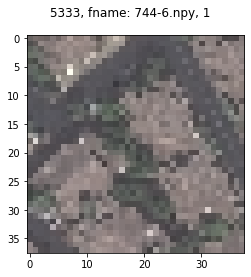

In [141]:
i = int(torch.rand(1) * len(train_ds))
plt.imshow(train_ds[i][0].detach().permute(1, 2, 0))
plt.suptitle(f'{i}, fname: {train_ds.fnames[i]}, {train_ds[i][1]}')
plt.show()

In [ ]:
train_ds[5333]

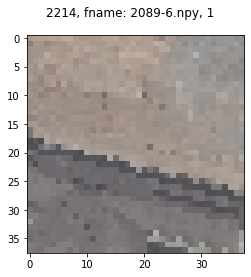

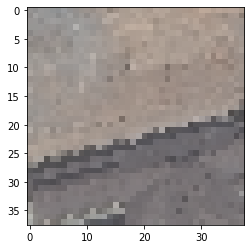

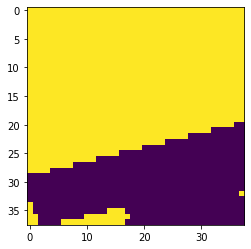

tensor(1)


In [152]:
i = int(torch.rand(1) * len(train_ds))
plt.imshow(train_ds[i][0].detach().permute(1, 2, 0))
plt.suptitle(f'{i}, fname: {train_ds.fnames[i]}, {train_ds[i][1]}')
plt.show()

im = np.load(f'data/train-img/{train_ds.fnames[i]}')
l = np.load(f'data/train-labels/{train_ds.fnames[i]}')
plt.imshow(im[..., [4, 2, 1]][::8, ::8])
plt.show()
plt.imshow(l[::8, ::8])
plt.show()
print((torch.tensor(l[::8, ::8]) == 1).any().long())

In [131]:
t = torch.rand(5)
print(t)

t[torch.tensor([True, False, True, False, True]).long().byte()]

tensor([0.2467, 0.3536, 0.2232, 0.4437, 0.4835])


tensor([0.2467, 0.2232, 0.4835])

torch.Size([64, 3, 7, 7])

## Visualization: Pre-trained Resnet18 7x7 filters

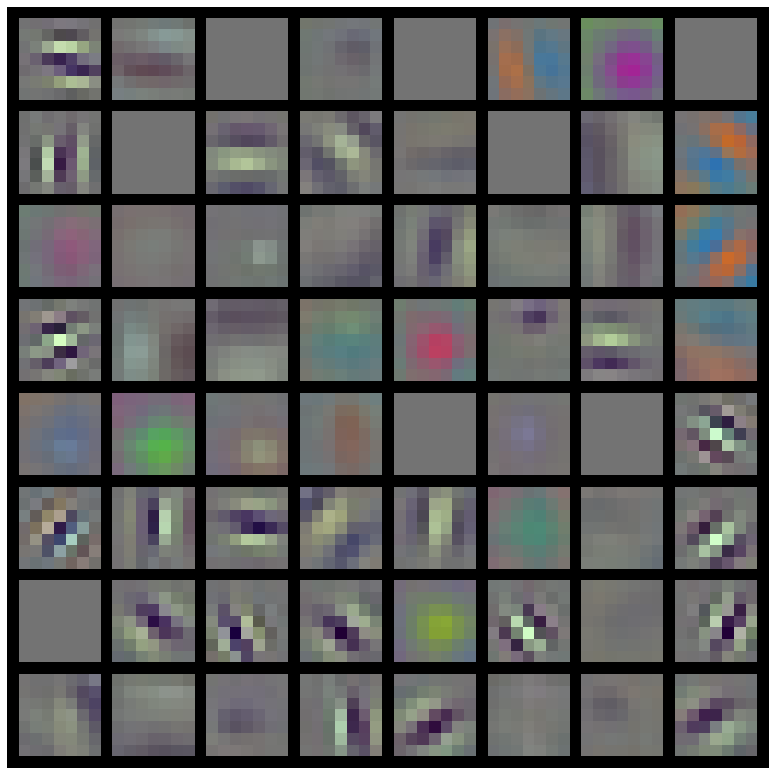

In [166]:
fs = model.net._modules['conv1'].weight.data.clone().detach().cpu()
grid = utils.make_grid(fs, normalize=True, padding=1).permute(1, 2, 0)

plt.figure(figsize=(14,14))
plt.imshow(grid)
how(grid, cmap='gray')
plt.axis('off')
plt.show()

## 3x3 filters trained on RGB

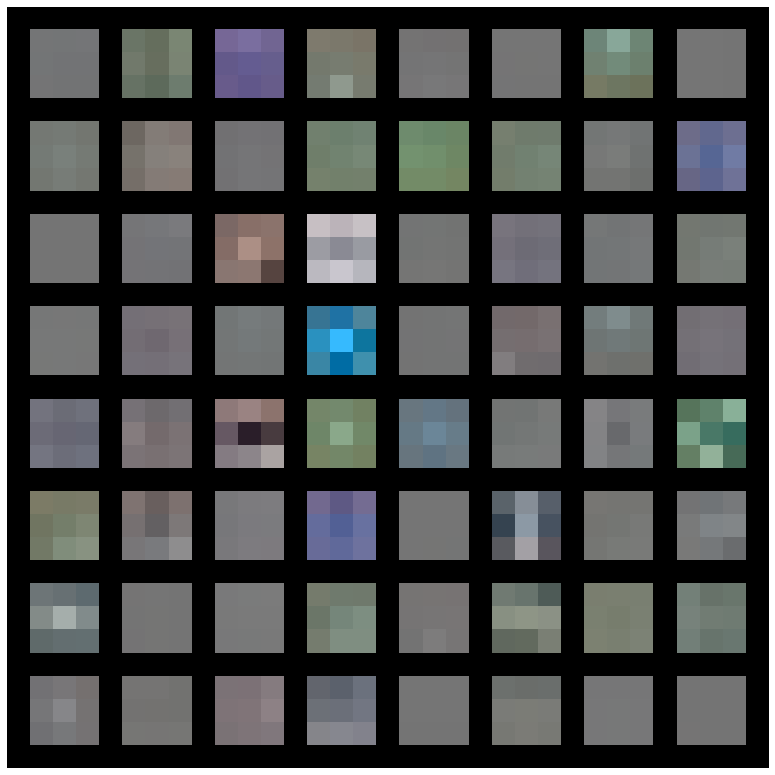

In [26]:
fs = model.net._modules['conv1'].weight.data.clone().detach().cpu()
grid = utils.make_grid(fs, normalize=True, padding=1).permute(1, 2, 0)

plt.figure(figsize=(14,14))
plt.imshow(grid)
plt.axis('off')
plt.show()

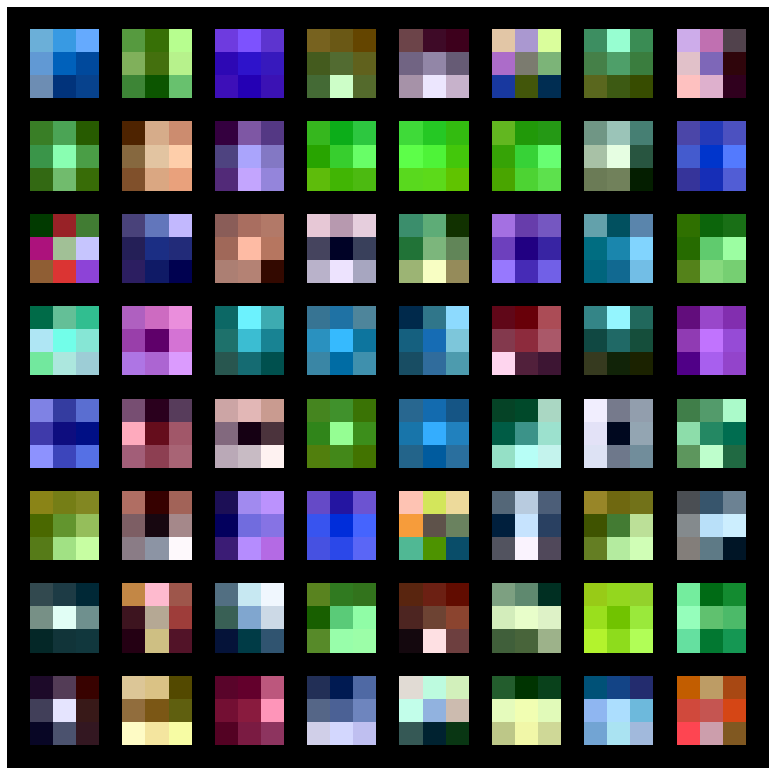

In [38]:
fs = model.net._modules['conv1'].weight.data.clone().detach().cpu()
grid = utils.make_grid(fs, normalize=True, scale_each=True, padding=1).permute(1, 2, 0)

plt.figure(figsize=(14,14))
plt.imshow(grid)
plt.axis('off')
plt.show()

## 3x3 filters trained on channels [7, 6, 5] (Near-IR2, Near-IR1, Red-Edge)

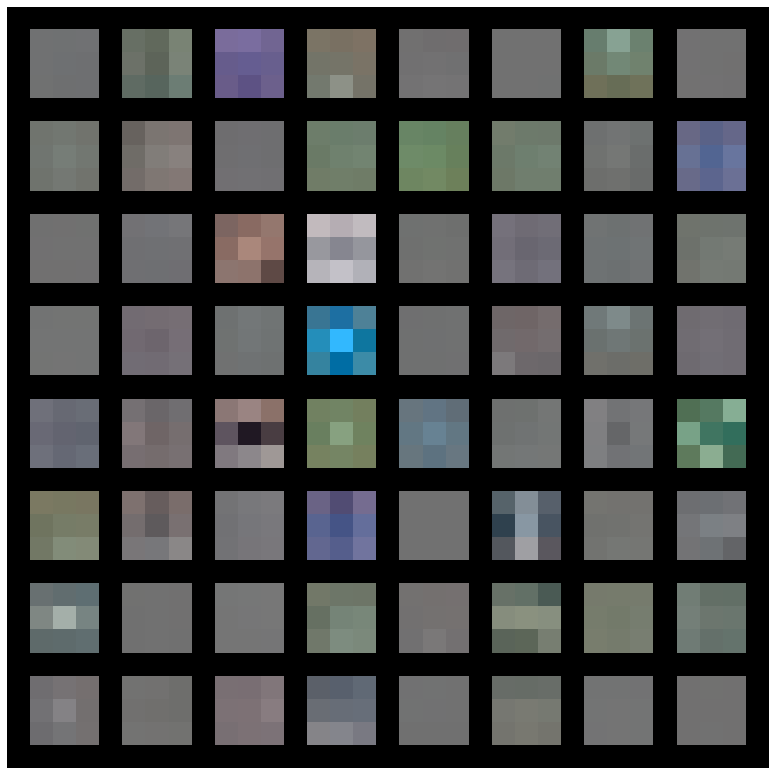

In [52]:
fs = model.net._modules['conv1'].weight.data.clone().detach().cpu()
grid = utils.make_grid(fs, normalize=True, padding=1).permute(1, 2, 0)

plt.figure(figsize=(14,14))
plt.imshow(grid)
plt.axis('off')
plt.show()

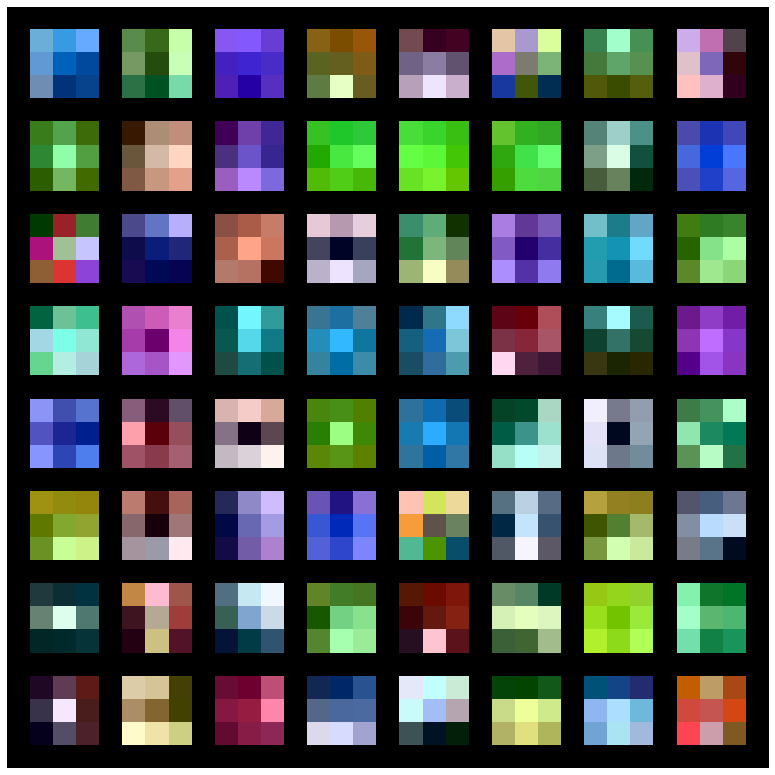

In [53]:
fs = model.net._modules['conv1'].weight.data.clone().detach().cpu()
grid = utils.make_grid(fs, normalize=True, scale_each=True, padding=1).permute(1, 2, 0)

plt.figure(figsize=(14,14))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [ ]:
plt.imshow(fs[0].permute(1, 2, 0).abs() / fs[0].max(), cmap='gray')